In [1]:
from kneed import DataGenerator, KneeLocator
import sys
import os
sys.path.append(os.path.abspath('../extraction'))
import matplotlib.pyplot as plt
import pandas as pd
import csv
import scipy.io
import json
import numpy as np
from format_data import *
from utils import *
import pickle
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from collections import Counter
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.neighbors import KNeighborsClassifier  # Importer KNeighborsClassifier
#from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import seaborn as sns
current_dir = os.getcwd()
positions_dir = os.path.join(current_dir, 'positions')
sys.path.append(positions_dir)
import resync as rs
from scipy.signal import find_peaks
from sklearn.model_selection import LeaveOneOut

fs = 160

In [7]:
import json

# Chemin vers le fichier JSON
file_path = 'Z:/eTheremin/ALTAI/ALTAI_20240725_SESSION_00/session_ALTAI_SESSION_00_20240725.json'

# Ouvrir et lire le fichier JSON
with open(file_path, 'r') as file:
    info = json.load(file)

In [6]:
t_pre = 0.2#0.2
t_post = 0.50#0.300
bin_width = 0.005
# Créer les bins de temps"
psth_bins = np.arange(-t_pre, t_post, bin_width)
#gc = np.arange(0, 32)

In [7]:
path = 'Y:/eTheremin/clara/ALTAI_20240822_SESSION_00/'
data = np.load(path+'data_ss_0.005.npy', allow_pickle=True)
# Check if the array is empty
if data.size == 0:
    print("The array is empty and cannot be reshaped.")
else:
    # Reshape the array if it is not empty
    reshaped_data = data.reshape((32, 841910))
    print("Reshaped data:", reshaped_data)
path_features = 'Z:/eTheremin/ALTAI/ALTAI_20240822_SESSION_00/headstage_0/'
features = np.load(path_features+'features_0.005.npy', allow_pickle=True)
gc = np.arange(len(data))

Reshaped data: [[0 0 1 ... 0 1 0]
 [1 0 0 ... 0 1 1]
 [0 1 3 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [8]:
len(features)

841911

positions

In [7]:
def clean_positions(positions):
    """
    Fonction de nettoyage des positions enregistrées au cours de l'expérience. Pour rappel, une valeur de -1, indique que le sujet n'a pas été détecté par le réseau de neurones.
    :param positions: 
    :return: 
    """
    y = np.where(positions == -1)[0]
    diff_y = np.diff(y)
    diff_y = np.vstack((np.arange(1, len(diff_y) + 1), diff_y)).T
    k = 0
    begin = 0
    for i, elt in diff_y:
        if elt != 1:
            positions[y[i - 1]] = positions[y[i - 1] + 1]
            positions[y[i]] = positions[y[i] - 1]
            if k != 0:
                end = y[i - 1]
                filler = np.full(shape=k, fill_value=positions[begin - 1])
                positions[begin:end] = filler
                k = 0
        else:
            if k == 0:
                begin = y[i - 1]
            k += 1
    remainder = np.where(positions == -1)[0]
    if len(remainder) != 0 and k != 0:
        pass

    return positions

In [8]:
path_pos = 'Z:/eTheremin/ALTAI/ALTAI_20240725_SESSION_00/' 
positions = rs.load_positions_file(path_pos)
print(positions)
positions = [file for file in positions if file != ""]
print(positions)

['Z:/eTheremin/ALTAI/ALTAI_20240725_SESSION_00/positions\\positions_tail_00_ALTAI_SESSION_00_20240725.bin', '', '', '', 'Z:/eTheremin/ALTAI/ALTAI_20240725_SESSION_00/positions\\positions_tracking_01_ALTAI_SESSION_00_20240725.bin', 'Z:/eTheremin/ALTAI/ALTAI_20240725_SESSION_00/positions\\positions_playback_01_ALTAI_SESSION_00_20240725.bin', 'Z:/eTheremin/ALTAI/ALTAI_20240725_SESSION_00/positions\\positions_tracking_02_ALTAI_SESSION_00_20240725.bin', 'Z:/eTheremin/ALTAI/ALTAI_20240725_SESSION_00/positions\\positions_playback_02_ALTAI_SESSION_00_20240725.bin', 'Z:/eTheremin/ALTAI/ALTAI_20240725_SESSION_00/positions\\positions_tracking_03_ALTAI_SESSION_00_20240725.bin', 'Z:/eTheremin/ALTAI/ALTAI_20240725_SESSION_00/positions\\positions_playback_03_ALTAI_SESSION_00_20240725.bin', 'Z:/eTheremin/ALTAI/ALTAI_20240725_SESSION_00/positions\\positions_tracking_04_ALTAI_SESSION_00_20240725.bin', 'Z:/eTheremin/ALTAI/ALTAI_20240725_SESSION_00/positions\\positions_playback_04_ALTAI_SESSION_00_2024072

In [64]:
#modifie ce code pour que les listes clen_x_p se mettent à la suite sans que ça créé des sous listes

x = []
y = []
#for k in range(len(positions)):

p = positions[0]
# Attention, positions en deux dimensions !
p = np.fromfile(p, dtype=np.int32)
x_p = p[np.arange(0, len(p), step=2)]
y_p = p[np.arange(1, len(p), step=2)]
mapping = rs.Mapping(1920, 33, 2000., 7)
clean_x_p = clean_positions(x_p)  # Pour retirer les -1.
clean_y_p = clean_positions(y_p)
x.extend(clean_x_p)
y.extend(clean_y_p) 
print(len(x))


47998


In [16]:
tone_vec = mapping.convert_to_frequency(x)
print(len(tone_vec))
print(len(features))

527989
721979


In [65]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# Données d'exemple (temps et positions)
# Supposons que vos données initiales ont un intervalle de 1/160 secondes (soit 0.00625 secondes)
temps_initial = np.arange(0, len(x)/160, 1/160)  # 10 secondes de données mesurées à 160 Hz


# Créer une interpolation linéaire à partir des données existantes
interpolateur = interp1d(temps_initial, x, kind='linear', fill_value="extrapolate")

# Définir le nouveau pas de temps (0.005 s)
nouveau_temps = np.arange(0, len(x)/160, 0.005)  # 10 secondes avec un échantillonnage de 0.005 s

# Interpoler pour obtenir les nouvelles positions à ce pas de temps plus fin
nv_x = interpolateur(nouveau_temps)

In [68]:
tone_vec = mapping.convert_to_frequency(x)
pos = nv_x.astype(np.int64)
freq_pos = mapping.convert_to_frequency(pos)
freq_features = [features[k]['Played_frequency'] for k in range(0, 61090)]
freq_features = np.array(freq_features)
print(len(freq_features))
print(len(freq_pos))

61090
59998


In [40]:
print(freq_features[1401:1500])
print(freq_pos[300:400])

[959. 959. 959. 959. 959. 959. 959. 959. 959. 959. 959. 959. 959. 959.
 959. 959. 959. 959. 959. 959. 959. 959. 959. 959. 959. 959. 959. 959.
 959. 959. 959. 959. 959. 959. 959. 959. 959. 959. 959. 959. 959. 959.
 959. 959. 959. 959. 959. 959. 959. 959. 959. 959. 959. 959. 959. 959.
 959. 959. 959. 959. 959. 959. 959. 959. 959. 959. 959. 959. 959. 959.
 959. 959. 959. 959. 959. 959. 959. 959. 959. 959. 959. 959. 959. 959.
 959. 959. 959. 959. 959. 959. 959. 959. 959. 959. 959. 959. 959. 959.
 959.]
[959. 959. 959. 959. 959. 959. 959. 959. 959. 959. 959. 959. 959. 959.
 959. 959. 959. 959. 959. 959. 959. 959. 959. 959. 959. 959. 959. 959.
 959. 959. 959. 959. 959. 959. 959. 959. 959. 959. 959. 959. 959. 959.
 959. 959. 959. 959. 959. 959. 959. 959. 959. 959. 959. 959. 959. 959.
 959. 959. 959. 959. 959. 959. 959. 959. 959. 959. 959. 959. 959. 959.
 959. 959. 959. 959. 959. 959. 959. 959. 959. 959. 959. 959. 959. 959.
 959. 959. 959. 959. 959. 959. 959. 959. 959. 959. 959. 959. 959. 959.

In [69]:
import numpy as np

def find_best_offset(freq_features, freq_pos):
    # Convertir les listes en tableaux NumPy
    freq_features = np.array(freq_features)
    freq_pos = np.array(freq_pos)

    len_features = len(freq_features)
    len_pos = len(freq_pos)

    # Créer un tableau qui contiendra les différences pour chaque offset
    mismatch_counts = np.zeros(len_features - len_pos + 1, dtype=int)

    # Calcul des différences pour chaque offset en utilisant NumPy
    for offset in range(len_features - len_pos + 1):
        mismatch_counts[offset] = np.sum(freq_features[offset:offset + len_pos] != freq_pos)

    # Trouver le décalage avec le moins de divergences
    best_offset = np.argmin(mismatch_counts)
    min_mismatches = mismatch_counts[best_offset]
    
    # Trouver les indices des divergences pour le meilleur offset
    mismatch_indices = np.where(freq_features[best_offset:best_offset + len_pos] != freq_pos)[0].tolist()

    return best_offset, mismatch_indices,min_mismatches

# Exemple d'utilisation
offset, mismatch_indices,min_mismatches = find_best_offset(freq_features, freq_pos)

if offset is not None:
    print(f"Meilleur décalage trouvé : {offset}")
    if mismatch_indices:
        print(f"Les listes ne coïncident pas aux indices suivants après décalage : {mismatch_indices}")
    else:
        print("Les listes coïncident complètement après décalage.")
else:
    print("Aucun décalage ne permet de faire coïncider les listes.")

Meilleur décalage trouvé : 1092
Les listes ne coïncident pas aux indices suivants après décalage : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 17, 168, 169, 170, 171, 172, 173, 174, 175, 176, 258, 259, 260, 261, 262, 263, 264, 265, 266, 1176, 1177, 1178, 1179, 1180, 1181, 1182, 1183, 1203, 1204, 1205, 1206, 1207, 1208, 1209, 1241, 1242, 1243, 1244, 1245, 1246, 1247, 1248, 1264, 1265, 1266, 1267, 1268, 1269, 1270, 1271, 1279, 1280, 1281, 1282, 1283, 1284, 1285, 1286, 1287, 1290, 1291, 1425, 1426, 1427, 1428, 1429, 1432, 1507, 1508, 1509, 1510, 1511, 1512, 1513, 1514, 1515, 1867, 1868, 1869, 1870, 1871, 1872, 1873, 2125, 2126, 2127, 2128, 2129, 2130, 2131, 2132, 2428, 2429, 2430, 2431, 2432, 2433, 2434, 2435, 2436, 2450, 2451, 2452, 2453, 2454, 2455, 2456, 2457, 2501, 2502, 2503, 2504, 2505, 2506, 2507, 2508, 2557, 2558, 2559, 2560, 2561, 2562, 2563, 2577, 2578, 2579, 2580, 2581, 2582, 2583, 2584, 2585, 2586, 2587, 2588, 2589, 2590, 2591, 2592, 2614, 2615, 2616, 2617, 2618, 2619, 2620, 2621, 2637, 26

In [70]:
print(len(mismatch_indices))

6654


In [ ]:
path = '/mnt/working4/clara/data2/eTheremin/ALTAI/ALTAI_20240725_SESSION_00/'

calcul de la vitesse "sur l'image"

In [13]:
print(features[5000:5020])

[{'Played_frequency': 1111.0, 'Condition': -1.0, 'Block': 0.0, 'Frequency_changes': False}
 {'Played_frequency': 1111.0, 'Condition': -1.0, 'Block': 0.0, 'Frequency_changes': False}
 {'Played_frequency': 1111.0, 'Condition': -1.0, 'Block': 0.0, 'Frequency_changes': False}
 {'Played_frequency': 1111.0, 'Condition': -1.0, 'Block': 0.0, 'Frequency_changes': False}
 {'Played_frequency': 1111.0, 'Condition': -1.0, 'Block': 0.0, 'Frequency_changes': False}
 {'Played_frequency': 1111.0, 'Condition': -1.0, 'Block': 0.0, 'Frequency_changes': False}
 {'Played_frequency': 1111.0, 'Condition': -1.0, 'Block': 0.0, 'Frequency_changes': False}
 {'Played_frequency': 1111.0, 'Condition': -1.0, 'Block': 0.0, 'Frequency_changes': False}
 {'Played_frequency': 1111.0, 'Condition': -1.0, 'Block': 0.0, 'Frequency_changes': False}
 {'Played_frequency': 1111.0, 'Condition': -1.0, 'Block': 0.0, 'Frequency_changes': False}
 {'Played_frequency': 1111.0, 'Condition': -1.0, 'Block': 0.0, 'Frequency_changes': False}

In [3]:
mapping = {
            '190.0':0,
            '220.0':1,
            '255.0':2,
            '296.0':3,
            '343.0':4,
            '397.0':5,
            '460.0':6,
            '533.0':7,
            '617.0':8,
            '715.0':9,
            '828.0':10,
            '959.0':11,
            '1111.0':12,
            '1287.0':13,
            '1490.0':14,
            '1727.0':15,
            '2000.0':16,
            '2317.0':17,
            '2684.0':18,
            '3109.0':19,
            '3601.0':20,
            '4172.0':21,
            '4832.0':22,
            '5598.0':23,
            '6484.0':24,
            '7511.0':25,
            '8701.0':26,
            '10079.0':27,
            '11676.0':28,
            '13525.0':29,
            '15667.0':30,
            '18149.0':31,
            '21024.0':32
}

In [7]:
def calcul_vitesse_features(features, mapping, condition):
    #la vitesse est en nombre de pixels par secondes
    c = {"tracking": 0, "playback": 1, "tail": -1, "mapping change": 2}.get(condition, None)
    ind = [0]
    poubelle = 0
    frequencies = []
    for k in range(1, len(features)):
        if c == 0:
            bool_change = features[k]['Frequency_changes']
        elif c == 1:
            bool_change = features[k]['Mock_change']      
        if bool_change and features[k]['Condition'] == c and 'Block' in features[k] and features[k]['Block'] in [1, 3, 5]:
            if c == 0:
                f = str(features[k]['Played_frequency'])
            elif c == 1:
                f = str(features[k]['Mock_frequency'])
            ind.append(k)
            frequencies.append(mapping[f])
        else : 
            poubelle += 1
    v = [1200 * (frequencies[k + 1] - frequencies[k]) / (33 * 0.005 * (ind[k + 1] - ind[k])) for k in range(len(ind) - 1)]
    return v,poubelle,ind

In [8]:
path = 'Y:/eTheremin/clara/ALTAI_20240806_SESSION_00/'
data = np.load(path+'data_ss_0.005.npy', allow_pickle=True)
path_features = 'Z:/eTheremin/ALTAI/ALTAI_20240806_SESSION_00/headstage_0/'
features = np.load(path_features+'features_0.005.npy', allow_pickle=True)
gc = np.arange(len(data))

In [9]:
v_tot = []
frequences = [[190,256],[296,398],[460,618],[715,960],[1111,1491],[1727,2318],
                [2684,3602],[4172,5599],[6484,8702],[10079,13526],[15667,21025]]
v_tot = []
for condition in ['tracking', 'playback']:
    v,poubelle,ind= calcul_vitesse_features(features, mapping, condition)
    v_tot.extend(v)
print(len(v_tot))

IndexError: list index out of range

In [16]:
v = np.abs(v_tot)
print(np.min(v),np.max(v),np.mean(v),np.std(v))

0.0 80000.0 1043.5321262649807 2254.1763241238546


{np.float64(0.026460425291800607): 1, np.float64(0.039449579738695846): 1, np.float64(0.040345539371951074): 1, np.float64(0.0539283790679693): 1, np.float64(0.07808759573661249): 1, np.float64(0.0834969475901588): 1, np.float64(0.08898969443719858): 1, np.float64(0.09864535269412789): 1, np.float64(0.09958411185287444): 1, np.float64(0.10217661739199292): 1, np.float64(0.10917224241150567): 1, np.float64(0.11570396946572245): 1, np.float64(0.11579485205036497): 1, np.float64(0.11638318873934457): 1, np.float64(0.11831729148056341): 1, np.float64(0.1189948504978447): 1, np.float64(0.11955430156377025): 1, np.float64(0.12001398162885975): 1, np.float64(0.12099231850017922): 1, np.float64(0.15770251096894886): 1, np.float64(0.16123278588084491): 1, np.float64(0.17768261886411943): 1, np.float64(0.24456664624535168): 1, np.float64(0.25873304894259036): 1, np.float64(0.2590094829846958): 1, np.float64(0.3157233691038044): 1, np.float64(0.35515178743455217): 1, np.float64(0.3785709891586732

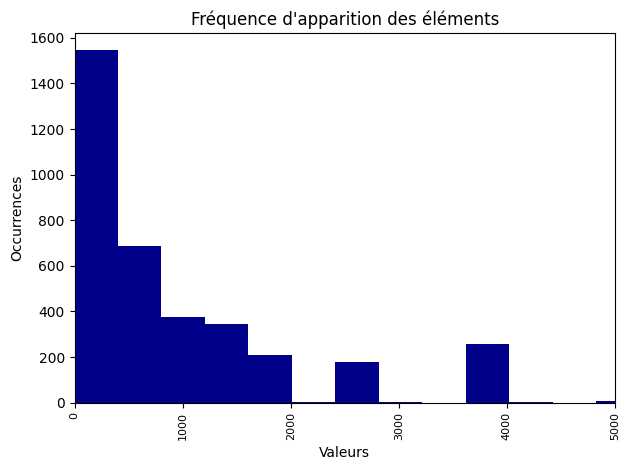

In [20]:
import matplotlib.pyplot as plt
from collections import Counter

# Compter les occurrences de chaque élément
frequency = Counter(np.abs(v_tot))
new_frequency = {k: v for k, v in sorted(frequency.items()) if k != np.float64(0.0)}

# Récupération des valeurs et de leurs fréquences
all_values = np.array(list(new_frequency.keys()))
print(new_frequency)
all_frequencies = np.array(list(new_frequency.values()))
# Définir des intervalles (bins) pour regrouper les données
bins = np.linspace(0, max(all_values), 200)  # 20 intervalles entre 0 et la valeur maximale
hist_values, bin_edges = np.histogram(all_values, bins=bins, weights=all_frequencies)

# Tracer l'histogramme avec les intervalles
plt.bar(bin_edges[:-1], hist_values, width=np.diff(bin_edges), color='darkblue', align='edge')

# Ajouter des labels et titre
plt.xlabel('Valeurs')
plt.ylabel('Occurrences')
plt.xlim(0,5000)
plt.title('Fréquence d\'apparition des éléments')

# Améliorer la lisibilité des axes
plt.xticks(rotation=90, fontsize=8)
plt.tight_layout()

# Afficher le graphique
plt.show()

In [11]:
def good_blocks(type,data,features,gc,frequency= None):
    blocks = [1,3,5]
    psths = []
    labels = []
    for block in blocks:
        psth,label = get_psth_in_block(data, features,t_pre, t_post, bin_width, gc, block, type, frequency)
        psth_transpose = np.moveaxis(psth, 1, 0) #(4104, 33, 2)
        label_transpose = np.moveaxis(label, 1, 0)
        psths.extend(psth_transpose)
        labels.extend(label_transpose)
    return psths,labels,gc

In [12]:
def KNN(session,type,psths,labels,gc,freq,size,label0,label1):      

    # print(len(labels),list(dict.fromkeys([len(labels[k]) for k in range(len(labels))])),list(dict.fromkeys([len(labels[k][i]) for k in range(len(labels)) for i in range(len(labels[k]))])))
    # print(len(psths),list(dict.fromkeys([len(psths[k]) for k in range(len(psths))])),list(dict.fromkeys([len(psths[k][i]) for k in range(len(psths)) for i in range(len(psths[k]))])))
    psths_condense = get_part_psth(psths, gc)
    # psths_transpose = np.moveaxis(psths_condense, 1, 0) #(4104, 33, 2)
    # label_transpose = np.moveaxis(labels, 1, 0)
    labels = np.array(labels)
    c0 = np.array(psths_condense)
    condition = labels[:,0,0]
    scaler = StandardScaler()

    # Initialiser le modèle KNN
    knn_classifier = KNeighborsClassifier(n_neighbors=5)  # Choisir le nombre de voisins
    #knn_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

    # Initialiser KFold avec 100 plis
    if size:
        cv = KFold(n_splits=100, shuffle=True, random_state=42)
    else :
        cv = LeaveOneOut()
    # Liste pour stocker les moyennes des précisions pour chaque bin
    mean_accuracies_per_bin = []
    res = []

    # Itérer sur chaque bin
    for bin in range(7):  # 7 bins
        c0_bin = c0[:,:,bin]  # Sélectionner les données pour le bin actuel
        
        # Standardisation des données pour le bin actuel
        psth_data_scaled = scaler.fit_transform(c0_bin)
        
        # Liste pour stocker les précisions pour chaque plis
        accuracies = []
        
        # Validation croisée
        for train_index, test_index in cv.split(psth_data_scaled):
            X_train, X_test = psth_data_scaled[train_index], psth_data_scaled[test_index]
            y_train, y_test = condition[train_index], condition[test_index]
            
            # Entraîner le modèle
            knn_classifier.fit(X_train, y_train)
            
            # Faire des prédictions
            y_pred = knn_classifier.predict(X_test)
            
            # Calculer et stocker l'accuracy
            accuracy = accuracy_score(y_test, y_pred)
            accuracies.append(accuracy)

        # Convertir la liste des précisions en tableau numpy
        accuracies = np.array(accuracies)
        
        # Calculer la moyenne de l'accuracy pour le bin courant
        mean_accuracy = np.mean(accuracies)
        std_accuracy = np.std(accuracies)
        mean_accuracies_per_bin.append(mean_accuracy)
        if min(label0, label1) > 100:
            n = 100
        else:
            n = label0 + label1

        # Calcul du score z
        z = np.sqrt(n) * (mean_accuracy - 0.5) / std_accuracy
        z = (mean_accuracy - 0.5) / std_accuracy  
        p_value = 1 - stats.norm.cdf(z) 
        res.append([session,mean_accuracy,std_accuracy,p_value,bin,type,freq,label0,label1])       # Afficher les résultats pour ce bin
        print(f"Bin {bin}: Moyenne de l'accuracy = {mean_accuracy:.4f}")
        print(f"Bin {bin}: Écart-type de l'accuracy = {np.std(accuracies):.4f}")
    return res,mean_accuracies_per_bin, accuracies, condition

In [13]:
session = 'ALTAI_20240806_SESSION_00'   
path = 'Y:/eTheremin/clara/' + session + '/'
path_features = 'Z:/eTheremin/ALTAI/' + session + '/headstage_0/'
data = np.load(path+'data_ss_0.005.npy', allow_pickle=True)
features = np.load(path+'features_0.005.npy', allow_pickle=True)
gc = np.arange(len(data))
v_min = 10
res_total = []
frequences = [[1727, 2318]]
for type in ['tracking','playback']:
    value_freq = []
    for freq in frequences:
        psths,labels,gc = good_blocks(type,data,features,gc,freq)
        v,poubelle,ind = calcul_vitesse_features(features, mapping, type, freq)
        print(len(v),poubelle,len(psths),len(labels))
        psth_filtré = [psths[k] for k in range(len(psths)) if np.abs(v[k]) >= v_min]
        label_filtré = [labels[k] for k in range(len(labels)) if np.abs(v[k]) >= v_min]
        v_filtré = [v[k] for k in range(len(v)) if np.abs(v[k]) >= v_min]
        print(len(v_filtré),len(psth_filtré),len(label_filtré)) 
        if label_filtré != [] and psth_filtré != []:
            l1 = [label_filtré[k][0][0] for k in range(len(label_filtré))]
            d1 = dict(Counter(l1))  
            value_freq.append(d1)
            print(d1)
            if 0 in d1 and 1 in d1:
                min_value = min(d1[0],d1[1])
                bool_size = (min_value > 100)
                res,mean_accuracies_per_bin, accuracies, condition = KNN(session,type,psth_filtré,label_filtré,gc,freq,bool_size,d1[0],d1[1])
            else:
                l0 = 0
                l1 = 0
                if 0 in d1:
                    l0 = d1[0]
                if 1 in d1:
                    l1 = d1[1]
                res = [[session,None,None,None,k,type,freq,l0,l1] for k in range(7)]
            res_total.extend(res)       
df = pd.DataFrame(res_total, columns = ['session', 'mean_accuracy', 'std_accuracy','p_value','bin','type','freq','nbr 0','nbr 1']) 
    # df.to_csv('Y:/eTheremin/clara/MUROLS dataframe/df_2.0'+ session + '.csv', index=False)

218 687422 341 341


IndexError: list index out of range

In [19]:
print(len(ind))

219


In [ ]:
mean_pbl = df[(df['type'] == 'playback') & (df['freq'] == '[6484, 8702]')]
mean_tra = df[(df['type'] == 'tracking') & (df['freq'] == '[6484, 8702]')]
mean_pbl = mean_pbl.drop_duplicates()
mean_tra = mean_tra.drop_duplicates()
mean_accuracies_per_bin_pbl = mean_pbl['mean_accuracy'].tolist()
mean_accuracies_per_bin_tra = mean_tra['mean_accuracy'].tolist()

print(mean_pbl)

plt.figure(figsize=(10, 6))

#Courbe pour l'accuracy en "playback"
plt.plot(range(7), mean_accuracies_per_bin_pbl, marker='o', color='deepskyblue', label='Playback', linestyle='-', linewidth=2)

#Courbe pour l'accuracy en "tracking"
plt.plot(range(7), mean_accuracies_per_bin_tra, marker='s', color='tomato', label='Tracking', linestyle='-', linewidth=2)

#Ajouter un titre et des labels
plt.title('Moyenne de l\'Accuracy par Bin (Playback vs Tracking)')
plt.xlabel('Temps en secondes')
plt.ylabel('Moyenne de l\'Accuracy')

#Légende des axes x
plt.xticks(range(7), labels=[f"{i * 0.1:.1f}" for i in range(7)])

#Ajouter une ligne verticale pour indiquer "Son"
plt.axvline(x=2, color='red', linestyle='--', label='Son')

#Définir l'échelle des ordonnées (limites de l'axe y entre 0.4 et 1)
plt.ylim(0.2, 1)

#Ajouter une grille
plt.grid(axis='y', linestyle='--', alpha=0.7)

#Ajouter une légende pour distinguer les courbes
plt.legend()

#Afficher le graphique
plt.show()

In [7]:
print(len(label_tracking_transpose_filtré))

1332


Bin 0: Moyenne de l'accuracy = 0.4710
Bin 0: Écart-type de l'accuracy = 0.0955
Bin 1: Moyenne de l'accuracy = 0.4856
Bin 1: Écart-type de l'accuracy = 0.1003
Bin 2: Moyenne de l'accuracy = 0.4951
Bin 2: Écart-type de l'accuracy = 0.1012
Bin 3: Moyenne de l'accuracy = 0.5141
Bin 3: Écart-type de l'accuracy = 0.0953
Bin 4: Moyenne de l'accuracy = 0.5046
Bin 4: Écart-type de l'accuracy = 0.0989
Bin 5: Moyenne de l'accuracy = 0.4985
Bin 5: Écart-type de l'accuracy = 0.1015
Bin 6: Moyenne de l'accuracy = 0.5094
Bin 6: Écart-type de l'accuracy = 0.1030


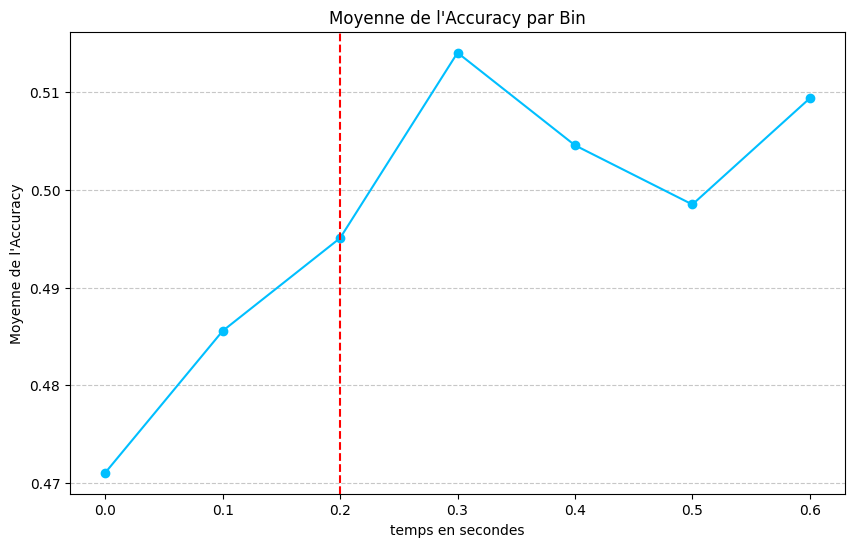

In [100]:
def KNN(session,type,tracking_transpose,label_tracking_transpose):
    c0 = np.array(tracking_transpose)
    condition = label_tracking_transpose[:,0,0]

    # Standardisation des données
    scaler = StandardScaler()

    # Initialiser le modèle KNN
    knn_classifier = KNeighborsClassifier(n_neighbors=5)  # Choisir le nombre de voisins
    #knn_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

    # Initialiser KFold avec 200 plis
    kf = KFold(n_splits=200, shuffle=True, random_state=42)

    # Liste pour stocker les moyennes des précisions pour chaque bin
    mean_accuracies_per_bin = []
    res = []

    # Itérer sur chaque bin
    for bin in range(7):  # 7 bins
        c0_bin = c0[:,:,bin]  # Sélectionner les données pour le bin actuel
        
        # Standardisation des données pour le bin actuel
        psth_data_scaled = scaler.fit_transform(c0_bin)
        
        # Liste pour stocker les précisions pour chaque plis
        accuracies = []
        
        # Validation croisée
        for train_index, test_index in kf.split(psth_data_scaled):
            X_train, X_test = psth_data_scaled[train_index], psth_data_scaled[test_index]
            y_train, y_test = condition[train_index], condition[test_index]
            
            # Entraîner le modèle
            knn_classifier.fit(X_train, y_train)
            
            # Faire des prédictions
            y_pred = knn_classifier.predict(X_test)
            
            # Calculer et stocker l'accuracy
            accuracy = accuracy_score(y_test, y_pred)
            accuracies.append(accuracy)

        # Convertir la liste des précisions en tableau numpy
        accuracies = np.array(accuracies)
        
        # Calculer la moyenne de l'accuracy pour le bin courant
        mean_accuracy = np.mean(accuracies)
        mean_accuracies_per_bin.append(mean_accuracy)
        res.append([session,mean_accuracy,bin,type])

        # Afficher les résultats pour ce bin
        print(f"Bin {bin}: Moyenne de l'accuracy = {mean_accuracy:.4f}")
        print(f"Bin {bin}: Écart-type de l'accuracy = {np.std(accuracies):.4f}")
    return res,mean_accuracies_per_bin

res,mean_accuracies_per_bin = KNN('ALTAI_20240725_SESSION_00','tracking',tracking_transpose,label_tracking_transpose)
# Tracer un diagramme à barres de la moyenne de l'accuracy pour chaque bin
plt.figure(figsize=(10, 6))
#je veux avoir un graph avec des points plutôt que des barres
# plt.bar(range(7), mean_accuracies_per_bin, color='deepskyblue')
plt.plot(range(7), mean_accuracies_per_bin, marker='o', color='deepskyblue')
plt.title('Moyenne de l\'Accuracy par Bin')
plt.xlabel('temps en secondes')
plt.ylabel('Moyenne de l\'Accuracy')
#légende l'axe des x
plt.xticks(range(7), labels=[f"{i * 0.1:.1f}" for i in range(7)])  
plt.axvline(x=2, color='red', linestyle='--', label='Son')

plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

In [101]:
print(res)

[['ALTAI_20240725_SESSION_00', np.float64(0.4710398860398861), 0, 'tracking'], ['ALTAI_20240725_SESSION_00', np.float64(0.48556267806267805), 1, 'tracking'], ['ALTAI_20240725_SESSION_00', np.float64(0.49507122507122503), 2, 'tracking'], ['ALTAI_20240725_SESSION_00', np.float64(0.5140527065527065), 3, 'tracking'], ['ALTAI_20240725_SESSION_00', np.float64(0.5045726495726496), 4, 'tracking'], ['ALTAI_20240725_SESSION_00', np.float64(0.49851139601139605), 5, 'tracking'], ['ALTAI_20240725_SESSION_00', np.float64(0.5093874643874643), 6, 'tracking']]


violin plot :
1. création du dataframe ['sessions','accuracy',bin','type']

In [ ]:
data = []
for session in sessions:
    res,mean_accuracies_per_bin_playback = KNN('ALTAI_20240725_SESSION_00',
                                                    'playback',playback_transpose,
                                                    label_playback_transpose)
    data.append(res)

In [ ]:
sns.violinplot(data=data, x='type', y='accuracy', split=True)  #hue='bin'